# Programming for data science
## Liner Models
### Linear Regression
#### Amir Hossein Akhavan Rahnama

Last run of the notebook: 

In [1]:
import time
import datetime

datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2019-11-05 11:09:00'

In this notebook, we replicate the example from Elements of Statistical Learning by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie (section 3.2.1).

We will be coding everything from scratch but in order to check our solution, we will be using Scikit Learn and StatsModels. 

As a personal preference, I would like to load all my modules at the top of my notebook. This makes it clear to the reader what type of libraries and what installations are needed.

**NOTE**: You need to run this notebook with Python 3+ only!

In [2]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from memory_profiler import profile
from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from model import *
from matplotlib.collections import LineCollection

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [6]:
np.random.seed(0)

### 2D example

Let us start with something simple:

In [7]:
x_train, y_train, x_test, y_test = synthetic_linear()

In [19]:
w_ols = np.matmul(np.linalg.inv(np.matmul(x_train.T, x_train)), np.matmul(x_train.T, y_train))
y_hat_ols_test = linear_implicit_bias(x_test, w_ols)
y_hat_ols_train = linear_implicit_bias(x_train, w_ols)

_mse = np.sum(np.square(y_hat_ols_test - y_test), axis=0) / (2 * x_train.shape[0])

In [20]:
'The solution found by OLS is {} and it has a MSE value of {}'.format(w_ols, _mse)

'The solution found by OLS is [-3.26827667  1.96067003] and it has a MSE value of 26.25407728255644'

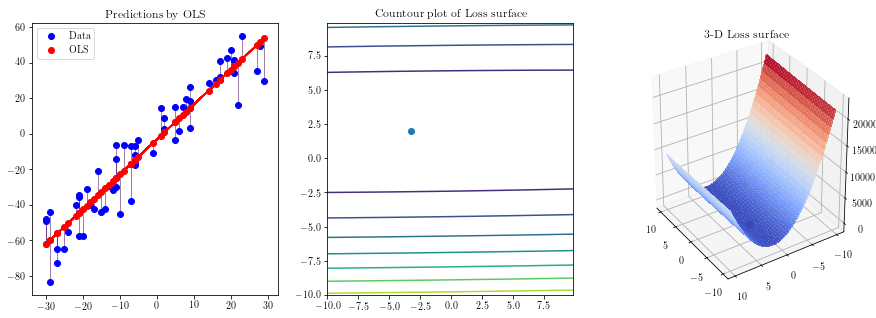

In [39]:
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

segments = [[[x_train[i, 1], y_train[i]], [x_train[i, 1], y_hat_ols_train[i]]] for i in range(training_size)]
lc = LineCollection(segments, zorder=0, color='green')
lc.set_array(np.ones(len(y_train)))
lc.set_linewidths(np.full(40, 0.5))

ax.scatter(x_train[:, 1], y_train, color='blue', label='Data')
ax.scatter(x_train[:, 1], y_hat_ols_train, color='red', label= 'OLS')
ax.plot(x_train[:, 1], y_hat_ols_train, color='red')
ax.set_title('Predictions by OLS')
plt.gca().add_collection(lc)
ax.legend()

ax = fig.add_subplot(1, 3, 2)

delta = 0.10
_w_ = np.arange(-10, 10, delta)
_w_0 = np.arange(-10, 10, delta)
W, W_0 = np.meshgrid(_w_, _w_0)

# Calculate loss surface
loss = []
for w, b in np.nditer([W, W_0]):
    _y_hat = linear(x_train[:, 1].reshape(training_size, 1), w.reshape(1), b.reshape(1))
    loss.append(np.square(_y_hat - y_train).sum()  /(2 * training_size))
loss_ = np.array(loss).reshape(W.shape)

ax.contour(W_0, W, loss_)
#ax.plot(w_ols[0], w_ols[1], linestyle='-', marker='o')
ax.scatter(w_ols[0], w_ols[1])
ax.set_title('Countour plot of Loss surface')


ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(W_0, W, loss_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.75)

_y_hat_ = linear(x_train[:, 1].reshape(training_size, 1), w_ols[1].reshape(1), w_ols[0].reshape(1))
ax.scatter(w_ols[0], w_ols[1], _y_hat_, color='black', marker='o', s=30)
ax.set_title('3-D Loss surface')
ax.view_init(30, 147)

plt.savefig('loss_surface_2d_ols.eps', format='eps')
plt.show()

### Gradient Descent

In [46]:
training_size = x_train.shape[0] 
x_train_norm = (x_train[:, 1] - x_train[:, 1].mean(axis=0))/x_train[:, 1].std(axis=0)
_w_gd_, _b_gd_, _w_trail_path, _b_trail_path = train_gd(x_train_norm.reshape(training_size, 1), y_train)
y_hat_gd_train = linear(x_train_norm.reshape(training_size, 1), _w_gd_, _b_gd_)
rss_gd = np.square(y_hat_ols_train - y_train).sum() / (2 * training_size)
rss_ols = np.square(y_hat_ols_train - y_train).sum() / (2 * training_size)

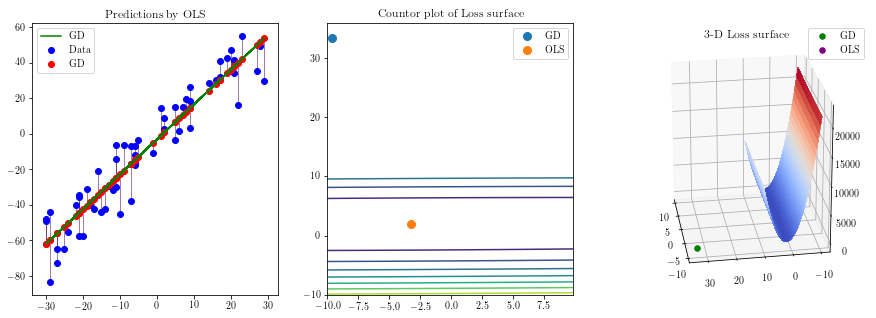

In [49]:
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

segments = [[[x_train[i, 1], y_train[i]], [x_train[i, 1], y_hat_ols_train[i]]] for i in range(training_size)]
lc = LineCollection(segments, zorder=0, color='green')
lc.set_array(np.ones(len(y_train)))
lc.set_linewidths(np.full(40, 0.5))

ax.scatter(x_train[:,1], y_train, color='blue', label='Data')
ax.scatter(x_train[:,1], y_hat_gd_train, color='red', label= 'GD')
ax.plot(x_train[:,1], y_hat_gd_train, color='green', label= 'GD')

ax.set_title('Predictions by OLS')
plt.gca().add_collection(lc)
ax.legend()

ax = fig.add_subplot(1, 3, 2)

delta = 0.10
_w_ = np.arange(-10, 10, delta)
_w_0 = np.arange(-10, 10, delta)
W, W_0 = np.meshgrid(_w_, _w_0)

# Calculate loss surface
loss = []
for w, b in np.nditer([W, W_0]):
    _y_hat = linear(x_train[:, 1].reshape(training_size, 1), w.reshape(1), b.reshape(1))
    loss.append(np.square(_y_hat - y_train).sum() / (2 * training_size))
loss_ = np.array(loss).reshape(W.shape)

ax.contour(W_0, W, loss_)
ax.scatter(_b_gd_, _w_gd_, rss_gd, label='GD')
ax.scatter(w_ols[0], w_ols[1], rss_ols, label='OLS')
ax.legend()
ax.set_title('Countor plot of Loss surface')

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(W_0, W, loss_, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.75)

ax.scatter(_b_gd_, _w_gd_, rss_gd, color='green', s=30, label='GD')
ax.scatter(w_ols[0], w_ols[1], rss_ols, color='purple', s=30, label='OLS')
ax.set_title('3-D Loss surface')
ax.view_init(22, 171)
ax.legend()

plt.savefig('loss_surface_2d_ols_gd.eps', format='eps')

plt.show()

### A real multivariate example

Let's load the data from the exampe:

In [53]:
X = pd.read_csv('http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/prostate.data', sep='\t', usecols=range(1, 11))

The data comes with its own training/test split. Let us divide the data:

In [54]:
X_train = X[X['train'] == 'T']
y_train = X_train['lpsa']
X_train = X_train.drop(columns=['lpsa', 'train'], axis=1)

X_test = X[X['train'] == 'F']
y_test = X_test['lpsa']
X_test = X_test.drop(columns=['lpsa', 'train'], axis=1)

Let us look at histograms of each variable: 

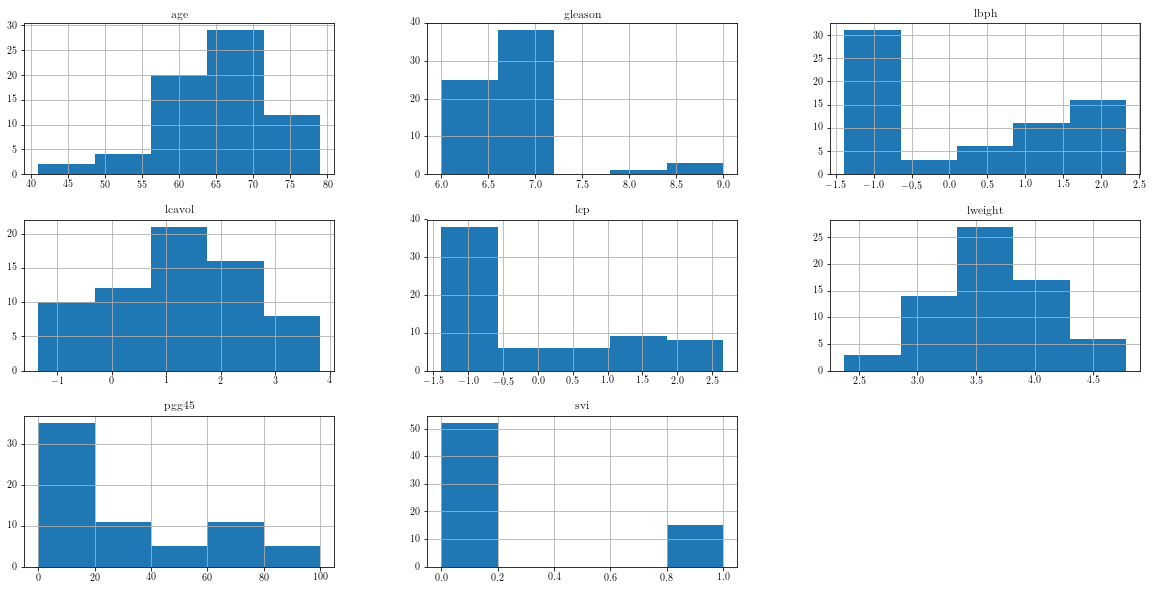

In [55]:
his = X_train.hist(figsize=(20,10), bins=5)

We need to normalize the predictors before fitting the model as mentioned in the book. It usually is a nice practice if you are not changing the distribution of your values, but basically aligning the center of all distibutions:

In [56]:
normalized_X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)

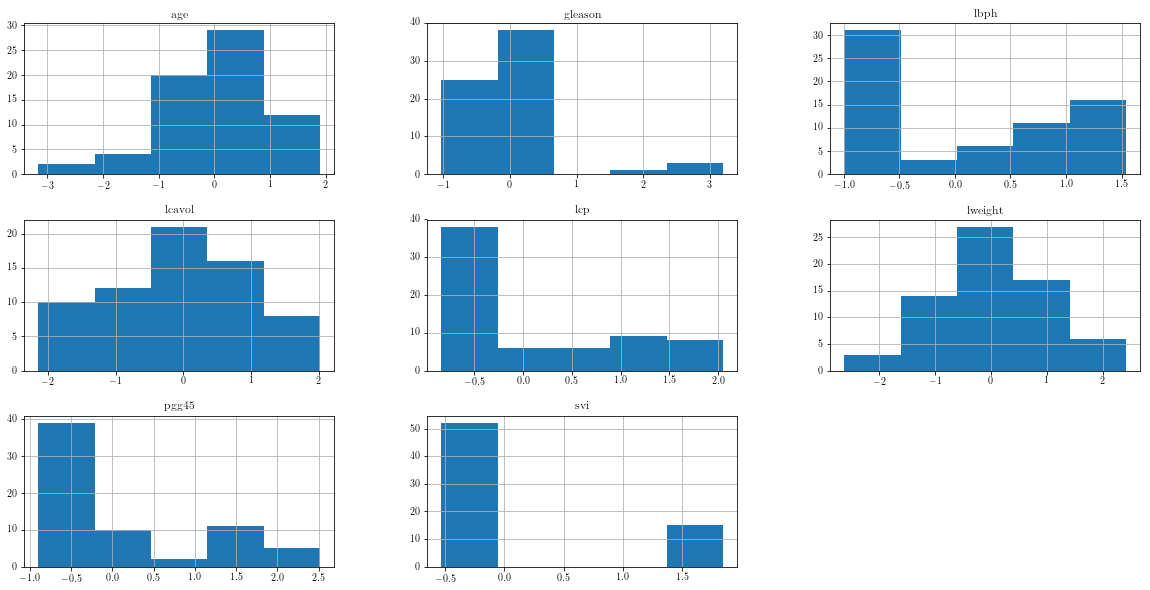

In [57]:
his_normalize = normalized_X_train.hist(figsize=(20,10), bins=5)

In [58]:
corr = X_train.corrwith(y_train)

In [59]:
for c in ['pearson', 'kendall', 'spearman']:
    print('Correlation between the dependent vs the outcome by {} measure:'.format(c))
    print('\n')
    print(X_train.corrwith(y_train, method=c).sort_values(ascending=False))
    print('\n')

Correlation between the dependent vs the outcome by pearson measure:


lcavol     0.733155
svi        0.556886
lcp        0.489203
lweight    0.485215
pgg45      0.448048
gleason    0.342428
lbph       0.262938
age        0.227642
dtype: float64


Correlation between the dependent vs the outcome by kendall measure:


lcavol     0.520281
svi        0.472867
pgg45      0.370928
lcp        0.349337
gleason    0.342401
lweight    0.338469
lbph       0.189063
age        0.185581
dtype: float64


Correlation between the dependent vs the outcome by spearman measure:


lcavol     0.708015
svi        0.574008
lweight    0.503003
pgg45      0.496249
lcp        0.464768
gleason    0.440042
age        0.248142
lbph       0.244336
dtype: float64




In [60]:
reg = LinearRegression(normalize=True).fit(normalized_X_train, y_train)

print('Intercept: {:6.3f}'.format(reg.intercept_))
for i, col in enumerate(X_train.columns):
    print('{:9s}: {:6.3f}'.format(col, reg.coef_[i]))

Intercept:  2.452
lcavol   :  0.716
lweight  :  0.293
age      : -0.143
lbph     :  0.212
svi      :  0.310
lcp      : -0.289
gleason  : -0.021
pgg45    :  0.277


### Ordinary Least Squares (OLS)

Okay, now we have used Scikit Learn's library to calculate the weights of the model. Scikit Learn performs OLS on the model. In here, we calculate the same weights ourselves and take things ever further. First and foremost, OLS assums that in your data matrix, namely $X$, you have included the bias (or the intercept). THere is a technique called the 'bias trick' that inserts the bias as a column of 1s in the original input matrix. In this section, we use the bias trick when using OLS:

In [61]:
normalized_X_train_bias = normalized_X_train.copy()
normalized_X_train_bias.insert(0, "intercept", np.ones(normalized_X_train.shape[0]))

OLS basically calculates $(X^TX)^{-1}X^T y$:

In [62]:
def OLS(_x, _y):
    _x_t = _x.T
    x_power_2 = np.matmul(_x_t, _x)
    inv_x_power_2 =  np.linalg.inv(x_power_2)
    inv_x_t = np.matmul(inv_x_power_2, _x_t) 
    w_hat = np.matmul(inv_x_t, _y)
    
    return w_hat

Using the values of $w$ found by OLS, we can calculate $\hat{y} = \hat{W} X$:

In [63]:
def _predict(_x, _w_hat):
    return np.matmul(_x, _w_hat) 

And Residual Sum of Sqaures (RSS) is calculated by $\sum_{i=1}^{N} (\hat{y} - y)^2$:

In [64]:
def RSS(y_hat, y_true):
    return np.sum(np.power(y_hat - y_true, 2), axis=0) 

### Variable importance and distribution of coefficient errors (self-study)

In [65]:
w_hat = OLS(normalized_X_train_bias.values, y_train) 

y_train_hat = _predict(normalized_X_train_bias.values, w_hat)
sigma_hat = RSS(y_train, y_train_hat)/(normalized_X_train_bias.shape[0] - normalized_X_train_bias.shape[1] - 1)
var_w_hat = np.diagonal(np.linalg.inv(np.matmul(normalized_X_train_bias.values.T, normalized_X_train_bias.values)) * sigma_hat)
z_score = w_hat / np.sqrt(sigma_hat) * np.sqrt(var_w_hat)

In [66]:
print('\t \t  coef \t\t  std error \t z-score')
for i, col in enumerate(normalized_X_train_bias.columns):
    print('{:9s} \t {:6.3f} \t {:6.3f}  \t {:6.3f}'.format(col, w_hat[i], np.sqrt(var_w_hat[i]), z_score[i]))

	 	  coef 		  std error 	 z-score
intercept 	  2.452 	  0.088  	  0.300
lcavol    	  0.716 	  0.135  	  0.134
lweight   	  0.293 	  0.107  	  0.044
age       	 -0.143 	  0.103  	 -0.020
lbph      	  0.212 	  0.104  	  0.031
svi       	  0.310 	  0.126  	  0.055
lcp       	 -0.289 	  0.156  	 -0.063
gleason   	 -0.021 	  0.144  	 -0.004
pgg45     	  0.277 	  0.161  	  0.062


Let's compare the result with standard packages:

### Model selection using F-statistic and ANOVA (self-study)

If we assume the Statistical significance threshold of $\alpha = 0.5$, a Z-score with absolute value of greater than 2 is significat.  

In [67]:
_normalized_X_train = normalized_X_train.copy()
_normalized_X_train = _normalized_X_train.drop(['age', 'lcp', 'gleason', 'pgg45'], axis=1)

In [68]:
w_hat_smaller_model = OLS(_normalized_X_train.values, y_train)
y_hat_smaller_model = _predict(_normalized_X_train.values, w_hat_smaller_model)

rss_0 = RSS(y_hat_smaller_model, y_train)
rss_1 = RSS(y_train_hat, y_train)

p_1 = normalized_X_train.shape[1]
p_0 = _normalized_X_train.shape[1]
N = normalized_X_train.shape[0]

In [69]:
f_statistic_enu = (rss_0-rss_1)/(p_1-p_0)
f_statistic_deno = (rss_1) / (N - p_1)

In [70]:
f_statistic = f_statistic_enu/ f_statistic_deno
f_statistic

203.67143535167133

Use the f-statistic to calculate the CDF of the F distribution to see if the smaller model is any better or not (Null hypothesis is that the smaller model outperforms the original model): 

In [71]:
import scipy
p_value = scipy.stats.f.cdf(f_statistic, 4, 58)

if (1 - p_value <= 0.05):
    print('The null hypothesis cannot be rejected')
else:
    print('The evidence is not strong enough')

The null hypothesis cannot be rejected


As we can see, we do not have enough evidence to believe the smaller model is better than the original model. You can further experiment with removing different subsets of features and see if the results differ ot not.

### Linear regression with gradient descent

In [85]:
_w, _b, _w_trail_path, _b_trail_path = train_gd(normalized_X_train_bias.values, y_train.values)

mse(y_train.values, linear_implicit_bias(normalized_X_train_bias.values, _w)) / normalized_X_train_bias.values.shape[0]

1.884486265522176